In [5]:
import pandas as pd
import numpy as np
import warnings
import pyodbc
import random
import os
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from sklearn.cluster import DBSCAN
from sklearn.cluster import KMeans
from collections import Counter
import multiprocessing as mp
import ray
import datetime

warnings.filterwarnings(action = 'ignore')

2023-12-05 10:57:37,902	INFO util.py:159 -- Outdated packages:
  ipywidgets==7.6.3 found, needs ipywidgets>=8
Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.


#### 유전 알고리즘 활용한 페어 트레이딩 v7

* v2
 - parameter 생성 시 공적분 검정 테스트를 추가하자 (train set 한도내에서)
 - child 생성 시 볼린저밴드 파라미터와 비중 2개로 나누어 crossover
 - mutation 시 볼린저밴드 파라미터 조정과 비중 shuffle

* v3
 - train set/test set 기간을 여러개로 나눠서 각 시뮬레이션 내 종목 비중과 결과 비교
 - 변이 이후 수선 기능을 추가. 각 파라미터의 정상성 테스트 후 p-value 0.05 이하인 것만 고르고 모자라다면 새로 생성
 
* v4
 - v2 + v3, 단 train set 기간 0.7에 대해 먼저 시뮬레이션 해보기
 - Clustering 기법을 도입해서 각 클러스터링 내 가장 score가 좋은 부모 쌍을 고르고 교배. 부모 + 자식 중 best fit을 고르고 변이를 적용해 클러스터링 내 개체 갯수만큼 숫자 채우기
 - Clustering은 KMeans 활용
 
* v5
 - parameter 생성 시 공적분 검정 테스트를 추가하자 (train set 한도내에서)
 - child 생성 시 볼린저밴드 파라미터와 비중 2개로 나누어 crossover
 - mutation 시 볼린저밴드 파라미터 조정과 비중 shuffle
 - 변이 이후 수선 기능을 추가. 각 파라미터의 정상성 테스트 후 p-value 0.05 이하인 것만 고르고 모자라다면 새로 생성
 - train set 기간 0.7에 대해 시뮬레이션 해보기
 - Clustering 활용. 각 개체 내 -비중을 기준으로 clustering. 각 cluster 내에서 child 생성 (이 때 - 숫자는 변하지 않는 식으로 child 생성). 이후 전체 개체 중 best, lucky, 초기생성으로 새로운 세대 추출
 - child 생성 시 elite technique 활용 (부,모,자식 중 가장 스코어 높은 유전체 선택)
 
* v6
 - parameter 생성 시 공적분 검정 테스트를 추가하자 (train set 한도내에서)
 - child 생성 시 볼린저 밴드 계산 기간과 비중 모두 arithmetic crossover 적용. 비중은 적용 후 롱/숏 비중 1로 맞춰주는 작업 추가 
 - mutation 시 볼린저밴드 파라미터 조정과 비중 shuffle
 - 변이 이후 수선 기능을 추가. 각 파라미터의 정상성 테스트 후 p-value 0.05 이하인 것만 고르고 모자라다면 새로 생성
 - train set 기간 0.7에 대해 시뮬레이션 해보기
 
* v7
 - parameter 생성 시 공적분 검정 테스트를 추가하자 (train set 한도내에서)
 - child 생성 시 볼린저 밴드 계산 기간과 비중 모두 BLX-alpha crossover 적용
 - mutation 시 랜덤넘버 생성을 통해 각 파라미터에 더하기
 - 변이 이후 수선 기능을 추가. 수선은 1) 롱/숏 비중을 1로 맞추고, 2) 각 파라미터의 정상성 테스트 후 p-value 0.05 이하인 것만 고르고 모자라다면 새로 생성
 - train set 기간 0.7에 대해 시뮬레이션 해보기
 
* v8
 - 비중 제한 없애기
 - child 생성 시 볼린저 밴드 계산 기간과 비중 모두 BLX-alpha crossover 적용
 - mutation 시 랜덤넘버 생성을 통해 각 파라미터에 더하기
 - 변이 이후 수선 기능 추가. 1) 롱/숏 비중 각 1로 맞추기
 - train set 기간 0.7에 대해 시뮬레이션 해보기
 - 정상성 테스트 제외: rolling base 기반 표준화를 사용하기 때문

* v8-2
 - v8을 여러번 돌리기

In [6]:
conn_pcor = pyodbc.connect('driver={Oracle in OraClient18Home1};dbq=PCOR;uid=EF0SEL;pwd=EF0SEL#076')
conn_quant = pyodbc.connect('driver={SQL Server};server=46.2.90.172;database=quant;uid=index;pwd=samsung@00')
conn_wisefn = pyodbc.connect('driver={SQL Server};server=46.2.90.172;database=wisefn;uid=index;pwd=samsung@00')

In [7]:
os.chdir("..")
os.chdir("..")

os.chdir('00_data')

#df_const = pd.read_json('230927_index_constituent.json')
df_prc_raw = pd.read_json('230927_stk_prc_daily.json')
#df_turnover = pd.read_json('230927_stk_turnover.json')
#df_sector = pd.read_json('230927_stk_sector.json')
#df_mktcap = pd.read_json('230927_stk_mktcap.json')
#df_turnover_daily = pd.read_json('231011_stk_turnover_daily.json')

os.chdir("..")
os.chdir('02_Trading Strategies')
os.chdir('231026_유전 알고리즘을 활용한 페어트레이딩')

In [8]:
sector_code = 'IKS013'

In [9]:
sql_dt = f'''
        SELECT TRD_DT, CLOSE_PRC
        FROM TS_IDX_DAILY
        WHERE 1=1
        AND SEC_CD = '{sector_code}'
        AND TRD_DT > '20091231'
        ORDER BY TRD_DT ASC
'''

df_dt = pd.read_sql(sql_dt, conn_wisefn)

In [10]:
df_dt['TRD_DT'] =  pd.to_datetime(df_dt['TRD_DT'])
df_dt['M'] = df_dt['TRD_DT'].dt.to_period('M')
dt_m = [max(df_dt[df_dt['M']==p]['TRD_DT']) for p in df_dt['M'].unique()]
dt_m = [int(x.strftime('%Y%m%d')) for x in dt_m]

In [11]:
def objective_func(df, params):
    
    #stk_list = sorted(list(set(df['COMP_CD'])))
    
    params_period = params[0]
    params_init = params[1]
    params_exit = params[2]
    params_wt = params[3:]

    df_sp = np.log(df) * params_wt
    df_sp = df_sp.sum(axis=1)
    
    df_sp_norm = (df_sp - df_sp.rolling(params_period).mean())/df_sp.rolling(params_period).std()
    df_sp_norm.dropna(axis=0, inplace=True)
    
    init_dt = []
    exit_dt = []
    init_yn = 0
    for i in range(len(df_sp_norm)):
        if init_yn == 0:
            if df_sp_norm.iloc[i] < params_init:
                init_dt.append(df_sp_norm.index[i])
                init_yn = 1
        
        elif init_yn == 1:
            if df_sp_norm.iloc[i] > params_exit:
                exit_dt.append(df_sp_norm.index[i])
                init_yn = 0
        
    if len(init_dt) > len(exit_dt):
        if len(init_dt) - len(exit_dt) > 1:
            print("error")
        else:
            init_dt = init_dt[:-1]
    
    ret_list = []
    cum_ret = 1
    for i in range(len(init_dt)):
        dt_1 = init_dt[i]
        dt_2 = exit_dt[i]
        
        prc_1 = df.loc[dt_1]
        prc_2 = df.loc[dt_2]
        
        ret = prc_2/prc_1 - 1
        ret = (ret * params_wt).sum()
        ret_list.append(ret)
        cum_ret *= (1+ret)
    
    return cum_ret

In [12]:
def generate_weight(length):
    
    pos_len = random.randint(1,length - 1)
    neg_len = length - pos_len
    
    pos_wt = []
    for i in range(pos_len):
        p = random.uniform(0,1)
        pos_wt.append(p)
    
    pos_wt = [x/sum(pos_wt) for x in pos_wt]
    
    neg_wt = []
    for i in range(neg_len):
        n = random.uniform(0,1)
        neg_wt.append(n)
    
    neg_wt = [-x/sum(neg_wt) for x in neg_wt]
    
    wt = pos_wt + neg_wt
    
    random.shuffle(wt)
    
    return wt  
        

def generate_params(df, length):
    
    params_period = random.randint(20,20*36)
    params_init = random.uniform(-4,0)
    params_exit = random.uniform(0,4)
    params_wt = generate_weight(length)
    
    params = [params_period, params_init, params_exit, *params_wt]
            
    return params
    

In [13]:
def generate_pop(df, size, length):
    population = []
    
    for i in range(size):
        
        params = generate_params(df,length)
        population.append(params)
        
    return population

In [14]:
def compute_performance(df, population):
    
    obj_list = []
    for individual in population:
        obj = objective_func(df, individual)
        obj_list.append([individual,obj])
    
    pop_sorted = sorted(obj_list, key=lambda x: x[1], reverse=True)
    
    return pop_sorted

In [15]:
def select_survivors(population_sorted, best_sample, lucky_few, length, df):
    
    next_gen = []
    
    for i in range(best_sample):
        if population_sorted[i][1] > 0:
            next_gen.append(population_sorted[i][0])
    
    lucky_index = np.random.choice(list(range(len(population_sorted))), lucky_few, replace=False)
    for i in lucky_index:
        next_gen.append(population_sorted[i][0])
    
    next_gen_2 = []
    for item in next_gen:
        if item not in next_gen_2:
            next_gen_2.append(item)
    
    
    while len(next_gen_2) < best_sample + lucky_few:
        next_gen_2.append(generate_params(df, length))
        
    random.shuffle(next_gen_2)
    
    return next_gen_2

In [16]:
def create_child(param1, param2, alpha):
    
    child = param1.copy()
    
    for i in range(len(child)):
        
        dist = abs(param1[i]-param2[i])
        
        l = min(param1[i],param2[i]) - alpha * dist
        u = max(param1[i],param2[i]) + alpha * dist

        child[i] = l + random.random() * (u-l)
    
    child[0] = int(np.round(child[0]))
    child[0] = min(20*36, child[0])
    child[0] = max(20, child[0])
    
    return child


def create_children(df, population, n_child, alpha, r_param):
    
    k = 0
    children = []

    fitness = [objective_func(df, x) for x in population]
    roulette = [x - min(fitness) + (max(fitness) - min(fitness))/(r_param - 1) for x in fitness]
    #fitness_2 = [x if x >= 0 else 0 for x in fitness]
    
    prob = [x/sum(roulette) for x in roulette]
    
    while k < n_child:
        try:
            sample = np.random.choice(list(range(len(prob))), 2, replace=True, p = prob)
        except:
            sample = np.random.choice(list(range(len(prob))), 2, replace=True)
        parents = [population[sample[0]], population[sample[1]]]
        
        child = create_child(parents[0], parents[1], alpha)
        children.append(child)
        
        k += 1

    return children

In [17]:
def mutation1(param, prob):
    
    r1 = random.random()
    
    param_mutate = param.copy()
    
    if r1 < prob:
        m1 = np.random.normal(0, 50)
        new_period = m1 + param[0]
        new_period = max(20, new_period)
        new_period = min(20*36, new_period)
        
        param_mutate[0] = int(np.round(new_period))
        
        m2 = np.random.normal(0,0.02,len(param) - 1)
        param_mutate[1:] = [x+y for (x,y) in zip(param_mutate[1:], m2)]
    
    return param_mutate


################################################
def mutate_pop(population, prob1):
    
    for i in range(len(population)):
        population[i] = mutation1(population[i], prob1)
    
    return population

In [18]:
def fix_1(population, df, length):
    
    # 수선: 비중 조절
    
    fixed_pop = []
    
    for child in population:
    
        child_wt = child[3:]
        child_pos = [x if x >= 0 else 0 for x in child_wt]
        child_neg = [x if x < 0 else 0 for x in child_wt]

        try:
            child_pos_adj = [x/sum(child_pos) for x in child_pos]
            child_neg_adj = [-x/sum(child_neg) for x in child_neg]
            child_wt_adj = [x+y for (x,y) in zip(child_pos_adj, child_neg_adj)]
            adj_child = child[:3] + child_wt_adj
        
        except:
            new_wt = generate_params(df, length)[3:]
            adj_child = child[:3] + new_wt
        
        fixed_pop.append(adj_child)
    
    return fixed_pop

In [19]:
def simulation_func(df, params):
    
    #stk_list = sorted(list(set(df['COMP_CD'])))
    
    params_period = params[0]
    params_init = params[1]
    params_exit = params[2]
    params_wt = params[3:]

    df_sp = np.log(df) * params_wt
    df_sp = df_sp.sum(axis=1)
    
    df_sp_norm = (df_sp - df_sp.rolling(params_period).mean())/df_sp.rolling(params_period).std()
    df_sp_norm.dropna(axis=0, inplace=True)
    
    init_dt = []
    exit_dt = []
    init_yn = 0
    for i in range(len(df_sp_norm)):
        if init_yn == 0:
            if df_sp_norm.iloc[i] < params_init:
                init_dt.append(df_sp_norm.index[i])
                init_yn = 1
        
        elif init_yn == 1:
            if df_sp_norm.iloc[i] > params_exit:
                exit_dt.append(df_sp_norm.index[i])
                init_yn = 0
        
    if len(init_dt) > len(exit_dt):
        if len(init_dt) - len(exit_dt) > 1:
            print("error")
        else:
            init_dt = init_dt[:-1]
    
    ret_list = []
    long_ret_list = []
    short_ret_list = []
    cum_ret = 1
    for i in range(len(init_dt)):
        dt_1 = init_dt[i]
        dt_2 = exit_dt[i]
        
        prc_1 = df.loc[dt_1]
        prc_2 = df.loc[dt_2]

        
        ret = prc_2/prc_1 - 1
        ret_ls = (ret * params_wt).sum()
        ret_list.append(ret_ls)        
        cum_ret *= (1+ret_ls)
        
        long_wt = [x if x >= 0 else 0 for x in params_wt]
        long_ret = (ret * long_wt).sum()
        long_ret_list.append(long_ret)
        
        short_wt = [x if x < 0 else 0 for x in params_wt]
        short_ret = (ret * short_wt).sum()
        short_ret_list.append(short_ret)
        
        
    
    return cum_ret, init_dt, exit_dt, ret_list, long_ret_list, short_ret_list

In [89]:
i = 0.75
base_d = dt_m[int(np.round(len(dt_m)*i,0))]
train_begin_dt = dt_m[0]
train_end_dt = base_d

sql_const = f'''
            SELECT TRD_DT, CONCAT('A',STK_CD) COMP_CD, STK_NM_KOR COMP_NM
            FROM TS_STK_ISSUE
            WHERE 1=1
            AND KS200_TYP = 1
            AND TRD_DT = '{base_d}'
            AND KSC_CD = '{sector_code}'
'''

df_const = pd.read_sql(sql_const, conn_wisefn)

df_train = df_prc_raw.copy()
df_train = df_train[df_train['TRD_DT'] >= train_begin_dt]
df_train = df_train[df_train['TRD_DT'] <= train_end_dt]
df_train = df_train[df_train['COMP_CD'].isin(df_const['COMP_CD'])]
df_train = df_train.sort_values(by = ['TRD_DT','COMP_CD'])
#stk_list = sorted(list(set(df_train['COMP_CD'])))


df_train = df_train.pivot(index = 'TRD_DT', columns = 'COMP_CD')
df_train = df_train.droplevel(axis = 1, level = 0)
#df_train = df_train[stk_list]
df_train.dropna(axis=1, inplace=True)
stk_list = sorted(list(df_train.columns))


df_test = df_prc_raw.copy()
df_test = df_test[df_test['TRD_DT'] >= train_end_dt]
#df_test = df_prc[df_prc['TRD_DT'] <= train_end_dt]
df_test = df_test[df_test['COMP_CD'].isin(df_const['COMP_CD'])]
df_test = df_test.sort_values(by = ['TRD_DT','COMP_CD'])

df_test = df_test.pivot(index = 'TRD_DT', columns = 'COMP_CD')
df_test = df_test.droplevel(axis = 1, level = 0)
df_test = df_test[stk_list]

In [91]:
mp.cpu_count()

16

In [92]:
ray.init(num_cpus=8)

2023-12-05 12:46:17,500	INFO worker.py:1664 -- Started a local Ray instance. View the dashboard at http://127.0.0.1:8265 


Python version:,3.8.8
Ray version:,2.8.0
Dashboard:,http://127.0.0.1:8265


In [93]:

def get_optimized_params(df_train, stk_list):
    
    #print(f'Train set: {train_begin_dt} ~ {train_end_dt}')
    #print(f'Test set: {train_end_dt} ~ {max(df_test.index)}')
    #print(' ')
    #print(f'유전 알고리즘 시작')
    n_generation = 200
    population = 500
    best_sample = int(population/4)
    lucky_few = int(population/4)
    prob1 = 0.02
    #prob2 = 0.01
    alpha = 0.10
    r_param = 4
    param_length = len(stk_list)

    pop = generate_pop(df_train, size = population, length = param_length)

    best_gene = []
    best_perf = []

    g = 0

    while True:

        pop_sorted = compute_performance(df_train, pop)

        survivors = select_survivors(pop_sorted, best_sample, lucky_few, param_length, df_train)

        children = create_children(df_train, survivors, population, alpha, r_param)

        new_generation = mutate_pop(children, prob1)

        if len(new_generation) < population:
            #print(f'  세대수 부족: {len(new_generation)}')
            break

        fixed_generation = fix_1(new_generation, df_train, param_length)

        pop = fixed_generation
        best_gene.append(pop_sorted[0][0])
        best_perf.append(pop_sorted[0][1])


        #print(f'====== {g}th generation ends ======')
        #print(pop_sorted[0])


        #gene_count = Counter([tuple(x[0]) for x in pop_sorted])
        #most_common_gene = gene_count.most_common(1)[0][1]
        pop_wt = [x[0][3:] for x in pop_sorted]
        dist_wt = [sum([(x-y)**2 for (x,y) in zip(pop_wt[0],z)]) for z in pop_wt]
        hurdle = 0.025
        dist_wt_hurdle = [1 for x in dist_wt if x < hurdle]

        #print(f'  최다 출현 개체수: {sum(dist_wt_hurdle)}')
        if sum(dist_wt_hurdle) > population * 0.7:
            break

        g += 1

        if g > n_generation:
            break

        print(' ')

    print(f'유전 알고리즘 종료')
    
    return pop_sorted[0][0], g
    

In [94]:
futures_2 = [get_optimized_params.remote(df_train, stk_list) for x in range(200)]

In [95]:
t1 = datetime.datetime.today()
optimized_params = ray.get(futures_2)

t2 = datetime.datetime.today()

lt = (t2 - t1).seconds

(get_optimized_params pid=7072)  
(get_optimized_params pid=21564)   [repeated 8x across cluster]
(get_optimized_params pid=21564)   [repeated 8x across cluster]
(get_optimized_params pid=21564)   [repeated 8x across cluster]
(get_optimized_params pid=21564)   [repeated 8x across cluster]
(get_optimized_params pid=16288)   [repeated 7x across cluster]
(get_optimized_params pid=21564)  
(get_optimized_params pid=7072)  
(get_optimized_params pid=16288)   [repeated 6x across cluster]
(get_optimized_params pid=21564)  
(get_optimized_params pid=7072)  
(get_optimized_params pid=16288)   [repeated 6x across cluster]
(get_optimized_params pid=21564)  
(get_optimized_params pid=30028)  
(get_optimized_params pid=16288)   [repeated 6x across cluster]
(get_optimized_params pid=30028)   [repeated 2x across cluster]
(get_optimized_params pid=21044)   [repeated 5x across cluster]
(get_optimized_params pid=16288)  
(get_optimized_params pid=21564)  
(get_optimized_params pid=18264)   [repeated 5x 

(get_optimized_params pid=7072) 유전 알고리즘 종료
(get_optimized_params pid=21044)   [repeated 2x across cluster]
(get_optimized_params pid=30028)   [repeated 3x across cluster]
(get_optimized_params pid=7072)   [repeated 3x across cluster]
(get_optimized_params pid=21564)   [repeated 3x across cluster]
(get_optimized_params pid=16288)   [repeated 3x across cluster]
(get_optimized_params pid=21044)   [repeated 4x across cluster]
(get_optimized_params pid=21564)  
(get_optimized_params pid=18264)  
(get_optimized_params pid=16288)   [repeated 2x across cluster]
(get_optimized_params pid=25064)   [repeated 3x across cluster]
(get_optimized_params pid=21564)   [repeated 2x across cluster]
(get_optimized_params pid=7072)   [repeated 3x across cluster]
(get_optimized_params pid=20056) 유전 알고리즘 종료
(get_optimized_params pid=25064)   [repeated 2x across cluster]
(get_optimized_params pid=21564)   [repeated 2x across cluster]
(get_optimized_params pid=7072)   [repeated 3x across cluster]
(get_optimized

(get_optimized_params pid=7072)   [repeated 5x across cluster]
(get_optimized_params pid=20056) 유전 알고리즘 종료
(get_optimized_params pid=16288)  
(get_optimized_params pid=30028)  
(get_optimized_params pid=21044) 유전 알고리즘 종료
(get_optimized_params pid=7072)   [repeated 4x across cluster]
(get_optimized_params pid=16288)   [repeated 2x across cluster]
(get_optimized_params pid=21044)   [repeated 2x across cluster]
(get_optimized_params pid=20056)   [repeated 5x across cluster]
(get_optimized_params pid=16288)  
(get_optimized_params pid=21044)  
(get_optimized_params pid=7072)   [repeated 5x across cluster]
(get_optimized_params pid=16288)   [repeated 2x across cluster]
(get_optimized_params pid=30028) 유전 알고리즘 종료
(get_optimized_params pid=21564)   [repeated 3x across cluster]
(get_optimized_params pid=21044)   [repeated 4x across cluster]
(get_optimized_params pid=21564)   [repeated 4x across cluster]
(get_optimized_params pid=21044)   [repeated 4x across cluster]
(get_optimized_params pid=1

(get_optimized_params pid=21564)   [repeated 3x across cluster]
(get_optimized_params pid=16288)   [repeated 2x across cluster]
(get_optimized_params pid=7072)   [repeated 5x across cluster]
(get_optimized_params pid=20056)   [repeated 2x across cluster]
(get_optimized_params pid=21044)   [repeated 5x across cluster]
(get_optimized_params pid=21564)  
(get_optimized_params pid=7072) 유전 알고리즘 종료
(get_optimized_params pid=20056)  
(get_optimized_params pid=25064)   [repeated 3x across cluster]
(get_optimized_params pid=21564)   [repeated 3x across cluster]
(get_optimized_params pid=30028)   [repeated 4x across cluster]
(get_optimized_params pid=7072)   [repeated 4x across cluster]
(get_optimized_params pid=30028)   [repeated 4x across cluster]
(get_optimized_params pid=25064)   [repeated 2x across cluster]
(get_optimized_params pid=21044) 유전 알고리즘 종료
(get_optimized_params pid=7072)  
(get_optimized_params pid=21564)  
(get_optimized_params pid=18264)   [repeated 4x across cluster]
(get_opt

(get_optimized_params pid=21564)  
(get_optimized_params pid=7072) 유전 알고리즘 종료
(get_optimized_params pid=20056)  
(get_optimized_params pid=18264) 유전 알고리즘 종료
(get_optimized_params pid=25064)   [repeated 2x across cluster]
(get_optimized_params pid=21564)   [repeated 3x across cluster]
(get_optimized_params pid=18264)   [repeated 5x across cluster]
(get_optimized_params pid=7072)   [repeated 3x across cluster]
(get_optimized_params pid=30028)   [repeated 3x across cluster]
(get_optimized_params pid=7072)   [repeated 5x across cluster]
(get_optimized_params pid=20056)   [repeated 2x across cluster]
(get_optimized_params pid=16288)   [repeated 4x across cluster]
(get_optimized_params pid=7072)   [repeated 2x across cluster]
(get_optimized_params pid=20056)   [repeated 2x across cluster]
(get_optimized_params pid=7072)   [repeated 6x across cluster]
(get_optimized_params pid=20056)   [repeated 2x across cluster]
(get_optimized_params pid=30028)   [repeated 5x across cluster]
(get_optimized_

(get_optimized_params pid=21564)   [repeated 2x across cluster]
(get_optimized_params pid=21044)  
(get_optimized_params pid=20056)  
(get_optimized_params pid=18264) 유전 알고리즘 종료
(get_optimized_params pid=30028)   [repeated 2x across cluster]
(get_optimized_params pid=21564)   [repeated 3x across cluster]
(get_optimized_params pid=18264)  
(get_optimized_params pid=21044)  
(get_optimized_params pid=20056) 유전 알고리즘 종료
(get_optimized_params pid=25064)   [repeated 3x across cluster]
(get_optimized_params pid=7072) 유전 알고리즘 종료
(get_optimized_params pid=18264)   [repeated 2x across cluster]
(get_optimized_params pid=16288)   [repeated 4x across cluster]
(get_optimized_params pid=25064) 유전 알고리즘 종료
(get_optimized_params pid=18264)   [repeated 3x across cluster]
(get_optimized_params pid=16288)   [repeated 4x across cluster]
(get_optimized_params pid=20056)   [repeated 4x across cluster]
(get_optimized_params pid=16288)   [repeated 3x across cluster]
(get_optimized_params pid=20056)   [repeated 

(get_optimized_params pid=21044)   [repeated 2x across cluster]
(get_optimized_params pid=16288)   [repeated 2x across cluster]
(get_optimized_params pid=20056)   [repeated 2x across cluster]
(get_optimized_params pid=21564) 유전 알고리즘 종료
(get_optimized_params pid=21044)   [repeated 2x across cluster]
(get_optimized_params pid=18264) 유전 알고리즘 종료
(get_optimized_params pid=7072)   [repeated 3x across cluster]
(get_optimized_params pid=20056)   [repeated 3x across cluster]
(get_optimized_params pid=21044)   [repeated 2x across cluster]
(get_optimized_params pid=7072)   [repeated 3x across cluster]
(get_optimized_params pid=20056) 유전 알고리즘 종료
(get_optimized_params pid=16288)   [repeated 4x across cluster]
(get_optimized_params pid=25064)   [repeated 2x across cluster]
(get_optimized_params pid=18264)   [repeated 4x across cluster]
(get_optimized_params pid=16288)   [repeated 2x across cluster]
(get_optimized_params pid=21564)   [repeated 2x across cluster]
(get_optimized_params pid=25064) 유전 알고

(get_optimized_params pid=25064)   [repeated 4x across cluster]
(get_optimized_params pid=20056)   [repeated 3x across cluster]
(get_optimized_params pid=16288)   [repeated 4x across cluster]
(get_optimized_params pid=25064)  
(get_optimized_params pid=7072)  
(get_optimized_params pid=20056) 유전 알고리즘 종료
(get_optimized_params pid=30028)  
(get_optimized_params pid=21044)  
(get_optimized_params pid=16288) 유전 알고리즘 종료 [repeated 2x across cluster]
(get_optimized_params pid=18264)  
(get_optimized_params pid=30028)  
(get_optimized_params pid=7072) 유전 알고리즘 종료
(get_optimized_params pid=18264)   [repeated 3x across cluster]
(get_optimized_params pid=30028)   [repeated 4x across cluster]
(get_optimized_params pid=25064) 유전 알고리즘 종료
(get_optimized_params pid=20056)   [repeated 2x across cluster]
(get_optimized_params pid=16288)   [repeated 4x across cluster]
(get_optimized_params pid=30028)  
(get_optimized_params pid=7072)  
(get_optimized_params pid=16288)   [repeated 5x across cluster]
(get_o

(get_optimized_params pid=21564) 유전 알고리즘 종료
(get_optimized_params pid=21044)   [repeated 2x across cluster]
(get_optimized_params pid=20056)   [repeated 2x across cluster]
(get_optimized_params pid=21564)   [repeated 3x across cluster]
(get_optimized_params pid=7072)   [repeated 2x across cluster]
(get_optimized_params pid=18264) 유전 알고리즘 종료
(get_optimized_params pid=30028)   [repeated 2x across cluster]
(get_optimized_params pid=25064)   [repeated 4x across cluster]
(get_optimized_params pid=21044)   [repeated 3x across cluster]
(get_optimized_params pid=21564)   [repeated 3x across cluster]
(get_optimized_params pid=18264)   [repeated 3x across cluster]
(get_optimized_params pid=7072) 유전 알고리즘 종료
(get_optimized_params pid=30028)  
(get_optimized_params pid=21044)  
(get_optimized_params pid=20056) 유전 알고리즘 종료
(get_optimized_params pid=16288)   [repeated 2x across cluster]
(get_optimized_params pid=7072)   [repeated 3x across cluster]
(get_optimized_params pid=20056)   [repeated 2x acros

(get_optimized_params pid=20056)   [repeated 3x across cluster]
(get_optimized_params pid=25064)   [repeated 2x across cluster]
(get_optimized_params pid=16288)   [repeated 3x across cluster]
(get_optimized_params pid=20056)   [repeated 3x across cluster]
(get_optimized_params pid=25064)   [repeated 2x across cluster]
(get_optimized_params pid=16288)   [repeated 3x across cluster]
(get_optimized_params pid=20056)   [repeated 2x across cluster]
(get_optimized_params pid=30028)   [repeated 3x across cluster]
(get_optimized_params pid=7072) 유전 알고리즘 종료
(get_optimized_params pid=16288)   [repeated 2x across cluster]
(get_optimized_params pid=20056)   [repeated 2x across cluster]
(get_optimized_params pid=30028)   [repeated 3x across cluster]
(get_optimized_params pid=25064) 유전 알고리즘 종료
(get_optimized_params pid=16288)   [repeated 2x across cluster]
(get_optimized_params pid=20056) 유전 알고리즘 종료
(get_optimized_params pid=21564)   [repeated 2x across cluster]
(get_optimized_params pid=16288)   [r

(get_optimized_params pid=30028)   [repeated 2x across cluster]
(get_optimized_params pid=18264)   [repeated 5x across cluster]
(get_optimized_params pid=20056)   [repeated 2x across cluster]
(get_optimized_params pid=7072)   [repeated 2x across cluster]
(get_optimized_params pid=18264)   [repeated 4x across cluster]
(get_optimized_params pid=20056)   [repeated 2x across cluster]
(get_optimized_params pid=16288)   [repeated 3x across cluster]
(get_optimized_params pid=21564)   [repeated 2x across cluster]
(get_optimized_params pid=25064) 유전 알고리즘 종료
(get_optimized_params pid=18264)  
(get_optimized_params pid=30028)  
(get_optimized_params pid=21044)   [repeated 4x across cluster]
(get_optimized_params pid=30028)   [repeated 3x across cluster]
(get_optimized_params pid=20056) 유전 알고리즘 종료
(get_optimized_params pid=25064)   [repeated 4x across cluster]
(get_optimized_params pid=30028)   [repeated 3x across cluster]
(get_optimized_params pid=18264)   [repeated 4x across cluster]
(get_optimi

(get_optimized_params pid=30028)   [repeated 4x across cluster]
(get_optimized_params pid=16288)   [repeated 3x across cluster]
(get_optimized_params pid=25064)   [repeated 4x across cluster]
(get_optimized_params pid=30028)  
(get_optimized_params pid=16288)  
(get_optimized_params pid=20056) 유전 알고리즘 종료
(get_optimized_params pid=25064)   [repeated 5x across cluster]
(get_optimized_params pid=30028) 유전 알고리즘 종료
(get_optimized_params pid=20056)   [repeated 2x across cluster]
(get_optimized_params pid=21044) 유전 알고리즘 종료
(get_optimized_params pid=30028)   [repeated 5x across cluster]
(get_optimized_params pid=20056)   [repeated 2x across cluster]
(get_optimized_params pid=30028)   [repeated 6x across cluster]
(get_optimized_params pid=16288)  
(get_optimized_params pid=20056)  
(get_optimized_params pid=21564)   [repeated 4x across cluster]
(get_optimized_params pid=16288)   [repeated 3x across cluster]
(get_optimized_params pid=7072)   [repeated 3x across cluster]
(get_optimized_params pid

(get_optimized_params pid=18264)   [repeated 3x across cluster]
(get_optimized_params pid=7072)   [repeated 3x across cluster]
(get_optimized_params pid=30028)   [repeated 4x across cluster]
(get_optimized_params pid=18264)  
(get_optimized_params pid=16288)  
(get_optimized_params pid=21044)   [repeated 3x across cluster]
(get_optimized_params pid=18264)   [repeated 4x across cluster]
(get_optimized_params pid=20056)   [repeated 3x across cluster]
(get_optimized_params pid=25064) 유전 알고리즘 종료
(get_optimized_params pid=21564)   [repeated 3x across cluster]
(get_optimized_params pid=18264)  
(get_optimized_params pid=16288)  
(get_optimized_params pid=20056)   [repeated 4x across cluster]
(get_optimized_params pid=18264)   [repeated 3x across cluster]
(get_optimized_params pid=30028)   [repeated 4x across cluster]
(get_optimized_params pid=21564) 유전 알고리즘 종료
(get_optimized_params pid=18264)   [repeated 3x across cluster]
(get_optimized_params pid=16288) 유전 알고리즘 종료
(get_optimized_params pid

In [97]:
lt/60

142.58333333333334

In [98]:
optimized_params_1 = [x[0] for x in optimized_params]
optimized_params_2 = [x[1] for x in optimized_params]

In [99]:
optimized_params_1

[[290,
  -0.9950938891493957,
  2.559675663503224,
  0.584087472295941,
  0.1345478193704632,
  -0.19678003432618557,
  0.08464140052688011,
  -0.0731484611442617,
  0.12378436744581907,
  -0.2739004615444789,
  0.07293894036089661,
  -0.1956434121752673,
  -0.2605276308098065],
 [261,
  -0.7956801779981642,
  2.666578408856074,
  0.2887393968911846,
  0.1569611332345051,
  -0.19669782304826933,
  0.11883312482588958,
  0.26891399905030505,
  0.11679154711595102,
  0.014198766004436305,
  0.03556203287772835,
  -0.06659591610568949,
  -0.7367062608460412],
 [250,
  -0.7579982434889511,
  2.527683504076317,
  0.3903705697293332,
  0.22951273461237948,
  -0.1767992535644396,
  0.11253536361548035,
  0.030984743577301892,
  0.1728245867749185,
  0.022354478228224364,
  0.04141752346236233,
  -0.08854343803726568,
  -0.7346573083982948],
 [213,
  -0.6894845242785348,
  2.4402322653603994,
  0.5548063546274197,
  0.21115723524535207,
  -0.1966744121106238,
  0.09948908532075638,
  -0.014868

In [100]:
df_optimized_params = pd.DataFrame(optimized_params_1)
df_optimized_steps = pd.DataFrame(optimized_params_2)

In [101]:
params_period = [x[0] for x in optimized_params_1]
params_init = [x[1] for x in optimized_params_1]
params_exit = [x[2] for x in optimized_params_1]
params_wt = [x[3:] for x in optimized_params_1]

(array([35., 13., 33., 32., 50., 20.,  4.,  0.,  3., 10.]),
 array([139., 168., 197., 226., 255., 284., 313., 342., 371., 400., 429.]),
 <BarContainer object of 10 artists>)

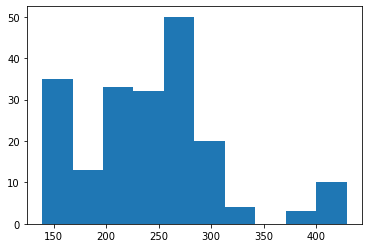

In [102]:
plt.hist(params_period)

(array([ 6.,  2.,  2.,  0.,  0.,  2., 24., 93., 59., 12.]),
 array([-2.58210065, -2.36593516, -2.14976967, -1.93360418, -1.71743868,
        -1.50127319, -1.2851077 , -1.06894221, -0.85277672, -0.63661122,
        -0.42044573]),
 <BarContainer object of 10 artists>)

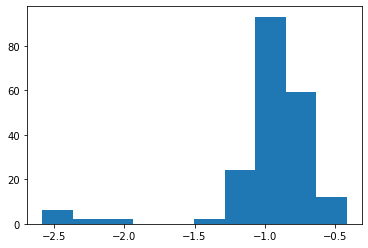

In [103]:
plt.hist(params_init)

(array([ 4.,  6., 25., 70., 80., 12.,  1.,  1.,  0.,  1.]),
 array([2.0613369 , 2.19482914, 2.32832139, 2.46181363, 2.59530588,
        2.72879812, 2.86229036, 2.99578261, 3.12927485, 3.26276709,
        3.39625934]),
 <BarContainer object of 10 artists>)

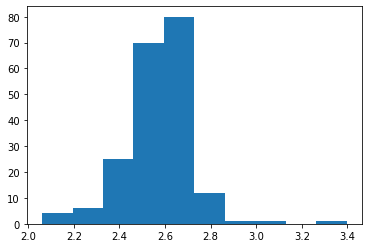

In [104]:
plt.hist(params_exit)

{'whiskers': [<matplotlib.lines.Line2D at 0x1ae27d4e1c0>,
 'caps': [<matplotlib.lines.Line2D at 0x1ae27d4e880>,
 'boxes': [<matplotlib.lines.Line2D at 0x1ae27d42e20>,
 'medians': [<matplotlib.lines.Line2D at 0x1ae27d4ef40>,
 'fliers': [<matplotlib.lines.Line2D at 0x1ae27d5a2e0>,
 'means': []}

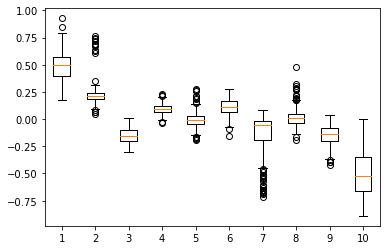

In [105]:
plt.boxplot(pd.DataFrame(params_wt))

In [106]:
df_optimized_params_norm = (df_optimized_params - df_optimized_params.mean(axis=0))/df_optimized_params.std(axis=0)

{'whiskers': [<matplotlib.lines.Line2D at 0x1ae27e2e400>,
 'caps': [<matplotlib.lines.Line2D at 0x1ae27e2eac0>,
 'boxes': [<matplotlib.lines.Line2D at 0x1ae27e2e0a0>,
 'medians': [<matplotlib.lines.Line2D at 0x1ae27e381c0>,
 'fliers': [<matplotlib.lines.Line2D at 0x1ae27e38520>,
 'means': []}

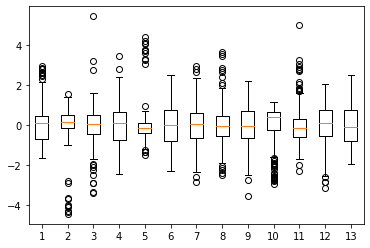

In [107]:
plt.boxplot(df_optimized_params_norm)

In [108]:
result_train = [simulation_func(df_train, x[0]) for x in optimized_params]
result_test = [simulation_func(df_test, x[0]) for x in optimized_params]

In [109]:
result_summary = pd.DataFrame([params_period, params_init, params_exit, [len(x[1]) for x in result_train],
              [len(x[1]) for x in result_test],[sum([1 for y in x[3] if y > 0]) for x in result_train],
              [sum([1 for y in x[3] if y > 0]) for x in result_test],
              [x[0] for x in result_train],[x[0] for x in result_test]], 
             index = ['period','init','exit','train_cnt','test_cnt','train_hr','test_hr','train_ret','test_ret']).T

result_summary.sort_values('period', inplace=True)

In [110]:
result_summary[result_summary['test_hr']!=0]

,period,init,exit,train_cnt,test_cnt,train_hr,test_hr,train_ret,test_ret
98,139.0,-1.241696,2.195631,14.0,2.0,14.0,2.0,13.142036,1.151096
9,148.0,-1.339073,2.726610,6.0,1.0,6.0,1.0,21.143970,1.258566
125,155.0,-0.791494,2.625383,8.0,1.0,8.0,1.0,21.350110,1.315985
20,155.0,-0.876446,2.333683,11.0,1.0,11.0,1.0,18.476445,1.291095
55,155.0,-0.945481,2.132690,14.0,1.0,14.0,1.0,15.075982,1.110286
...,...,...,...,...,...,...,...,...,...
43,292.0,-0.678007,2.620995,6.0,2.0,6.0,2.0,12.793734,1.825458
30,295.0,-1.262137,2.560528,5.0,1.0,5.0,1.0,8.044165,1.260596
27,296.0,-1.120919,2.505209,6.0,1.0,6.0,1.0,10.053894,1.457818
163,297.0,-0.913330,2.487887,6.0,1.0,6.0,1.0,10.068499,1.479792


In [111]:
params_avg = df_optimized_params.mean().to_list()
params_avg[0] = int(np.round(params_avg[0],0))
params_avg

[243,
 -0.9762413909238664,
 2.5722146746693006,
 0.487542970897232,
 0.23142818398300352,
 -0.15184766235138336,
 0.0941732538046523,
 -0.003134273236191892,
 0.11105049042701363,
 -0.14021008794252726,
 0.02247198553264302,
 -0.14854426173670554,
 -0.5029305993777362]

In [112]:
result_train_avg = simulation_func(df_train, params_avg)
result_test_avg = simulation_func(df_test, params_avg)

In [113]:
ret_train_avg = pd.DataFrame([result_train_avg[2], result_train_avg[3],result_train_avg[4],result_train_avg[5]], index = ['init_dt','ls','long','short']).T
ret_test_avg = pd.DataFrame([result_test_avg[2], result_test_avg[3],result_test_avg[4],result_test_avg[5]], index = ['init_dt','ls','long','short']).T

In [114]:
ret_train_avg

,init_dt,ls,long,short
0,20120328.0,0.273462,0.325110,-0.051647
1,20131004.0,0.248202,0.221769,0.026433
2,20150305.0,0.346062,0.205925,0.140137
3,20160930.0,0.369109,0.321464,0.047645
4,20180621.0,0.341394,0.243194,0.098200
5,20190812.0,0.266921,0.078275,0.188647


In [115]:
ret_test_avg

,init_dt,ls,long,short
0,20220211.0,0.301928,0.063978,0.237951


In [116]:
ray.shutdown()